In [1]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker
import matplotlib.pyplot as plt
import random
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Comparison of the three datasets  
Provide MLMarker with the complete set of proteins detected in the three different sample preps and study differences in predictions.  

In general: 
All samples show a testis as the most likely tissue. This is often observed in samples containing a lot of secretion, etc.  
Evo96 and proteochipD0 showed more similar prediction patterns compared to the proteochipPFA.  ==> follow up analysis, which proteins are different?   

In detail:  
Evo96 and proteochipD0 both show Retina, a neuronal-like tissue as second highest prediction which is promising!  
Evo96 is the only sample showing Brain as a possible tissue in its top 5.  

In [2]:
protein_lists = []
for i in ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']:    
    df = pd.read_csv(i, sep='\t')
    proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
    # if it contains ';' split it and take both
    proteins = [x.split(';') for x in proteins]
    proteins = [item for sublist in proteins for item in sublist]
    proteins = list(set(proteins))
    print(i, len(proteins))
    protein_lists.append(set(proteins))
    #make a dataframe with the proteins as column names, only one row and all values 1
    data = np.ones((1, len(proteins)))
    predict_df = pd.DataFrame(data, columns=proteins)

    test = MLMarker(predict_df.iloc[0:1,:], binary = True, dev=False)
    prediction = MLMarker.predict_top_tissues(test)
    print(i, prediction)

evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv 2764
evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv [('Testis', 0.2011), ('Retina', 0.1445), ('Parotid gland', 0.0651), ('Brain', 0.063), ('Adipose tissue', 0.0546)]
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv 3951
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv [('Testis', 0.2238), ('Retina', 0.1265), ('Esophagus', 0.0554), ('Parotid gland', 0.0529), ('Adipose tissue', 0.0522)]
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv 861
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv [('Testis', 0.1975), ('Prostate', 0.0908), ('B-cells', 0.0749), ('Urinary bladder', 0.0704), ('NK-cells', 0.0609)]


A standard PCA plot shows little difference between PFA and the others

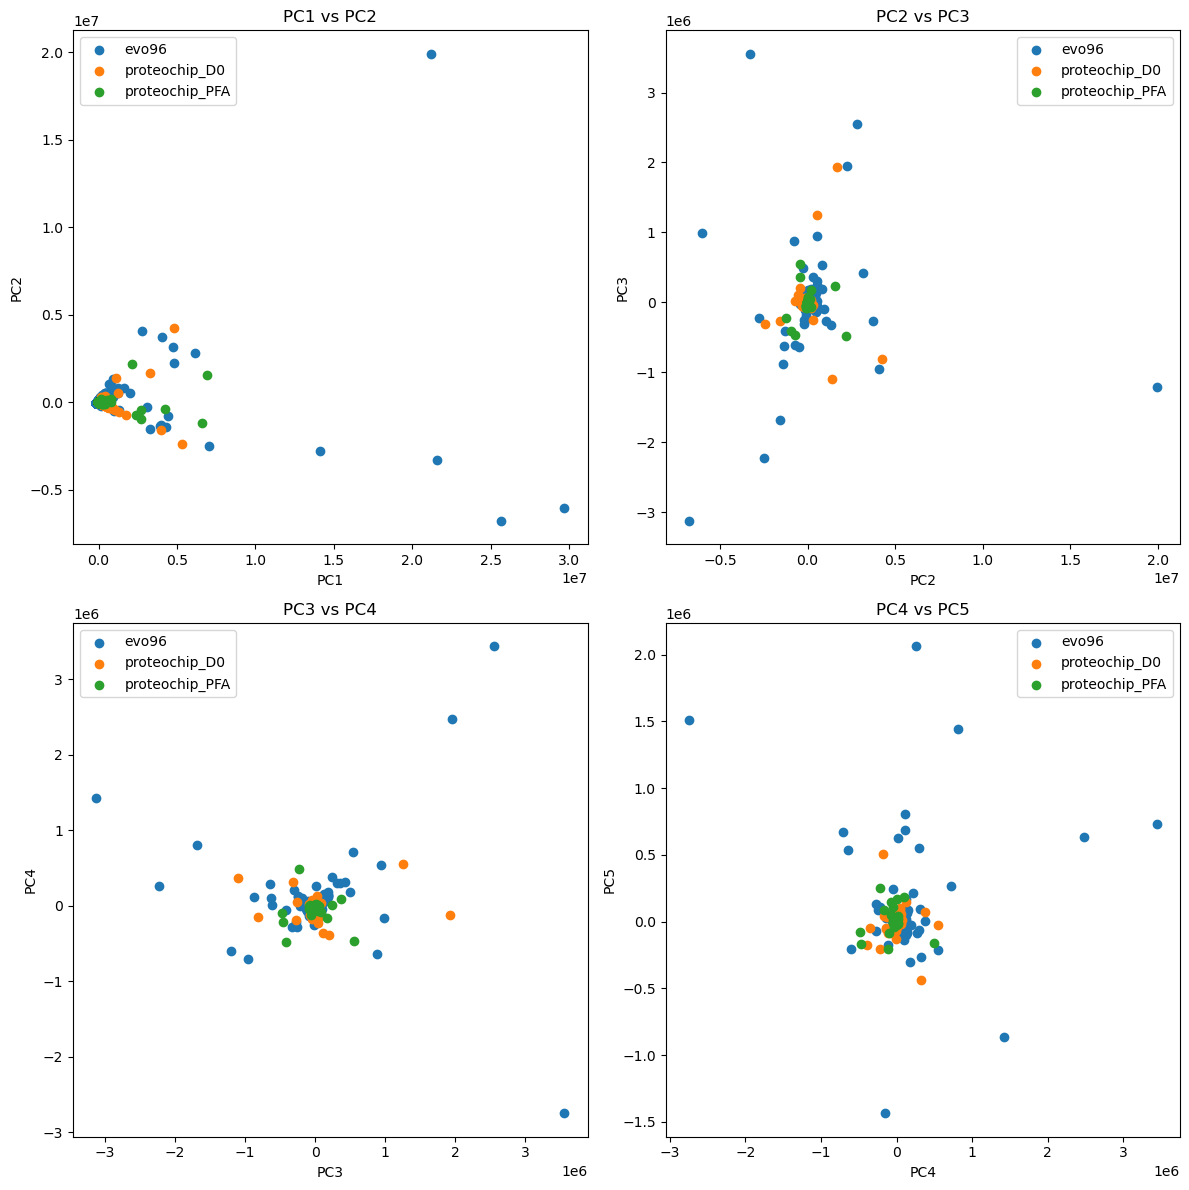

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Read the data
    df = pd.read_csv(dataset, sep='\t')
    data = df.iloc[:, 5:].fillna(0).values
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(data)
    
    # Plot the reduced data with color based on the dataset
    axs[0, 0].scatter(reduced_data[:, 0], reduced_data[:, 1], label=name)
    axs[0, 1].scatter(reduced_data[:, 1], reduced_data[:, 2], label=name)
    axs[1, 0].scatter(reduced_data[:, 2], reduced_data[:, 3], label=name)
    axs[1, 1].scatter(reduced_data[:, 3], reduced_data[:, 4], label=name)

# Add labels and titles for each subplot
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend()

axs[0, 1].set_title('PC2 vs PC3')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].legend()

axs[1, 0].set_title('PC3 vs PC4')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].legend()

axs[1, 1].set_title('PC4 vs PC5')
axs[1, 1].set_xlabel('PC4')
axs[1, 1].set_ylabel('PC5')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [4]:
import tqdm as tqdm

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']
# Create a new dataframe to store the predictions
prediction_df = pd.DataFrame(columns=['dataset', 'sample', 'n_proteins', 'Testis',  'Retina',  'Parotid gland',  'Brain',  'Adipose tissue',  'Prostate',  'NK-cells',  'Skeletal muscle',  'Urinary bladder',  'B-cells',  'Esophagus',  'T-cells',  'Ureter',  'Lymph node',  'Gall bladder',  'Tonsil',  'Placenta',  'Liver',  'Appendix',  'Heart',  'Small intestine',  'Adrenal gland',  'Colon',  'Ovary'])

for name, dataset in zip(names, datasets):
    print(f"started on {name}")
    df = pd.read_csv(dataset, sep='\t')
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    sub_df = df.set_index('Protein.Ids')
    sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
    sub_df = sub_df.T
    sub_df.fillna(0, inplace=True)
    sub_df = sub_df.astype(float)

    # Iterate over each row in sub_df
    for i in tqdm.tqdm(range(sub_df.shape[0])):
        test = MLMarker(sub_df.iloc[i:i+1,:], binary=True)
        prediction = MLMarker.predict_top_tissues(test, n_preds=100)
        new_name = str(name) + "_" + str(sub_df.index[i])
        num_nonzero_columns = (sub_df.iloc[i:i+1,:] != 0).sum(axis=1).values[0]
        num_nonzero_columns
        # Create a new row in prediction_df
        prediction_df = pd.concat([prediction_df, pd.DataFrame({'dataset': [name], 'sample': [new_name], 'n_proteins': [num_nonzero_columns]})], ignore_index=True)
        
        # Add the predictions to the new row
        for tissue, prob in prediction:
            prediction_df.loc[prediction_df.index[-1], tissue] = prob


started on evo96


  0%|          | 0/35 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  3%|▎         | 1/35 [00:01<01:07,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  6%|▌         | 2/35 [00:04<01:07,  2.05s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  9%|▊         | 3/35 [00:06<01:04,  2.02s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 11%|█▏        | 4/35 [00:08<01:01,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 14%|█▍        | 5/35 [00:10<00:59,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 17%|█▋        | 6/35 [00:12<00:57,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 20%|██        | 7/35 [00:13<00:55,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 23%|██▎       | 8/35 [00:15<00:53,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 26%|██▌       | 9/35 [00:17<00:51,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 29%|██▊       | 10/35 [00:19<00:49,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 31%|███▏      | 11/35 [00:21<00:47,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 34%|███▍      | 12/35 [00:23<00:45,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 37%|███▋      | 13/35 [00:25<00:43,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 40%|████      | 14/35 [00:28<00:42,  2.04s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 43%|████▎     | 15/35 [00:30<00:40,  2.03s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 46%|████▌     | 16/35 [00:32<00:38,  2.02s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 49%|████▊     | 17/35 [00:34<00:36,  2.01s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 51%|█████▏    | 18/35 [00:36<00:34,  2.01s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 54%|█████▍    | 19/35 [00:38<00:31,  2.00s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 57%|█████▋    | 20/35 [00:39<00:29,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 60%|██████    | 21/35 [00:41<00:27,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 63%|██████▎   | 22/35 [00:43<00:25,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 66%|██████▌   | 23/35 [00:45<00:23,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 69%|██████▊   | 24/35 [00:47<00:21,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 71%|███████▏  | 25/35 [00:49<00:19,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 74%|███████▍  | 26/35 [00:51<00:17,  1.98s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 77%|███████▋  | 27/35 [00:53<00:16,  2.03s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 80%|████████  | 28/35 [00:55<00:14,  2.02s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 83%|████████▎ | 29/35 [00:57<00:12,  2.01s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 86%|████████▌ | 30/35 [00:59<00:09,  2.00s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 89%|████████▊ | 31/35 [01:01<00:07,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 91%|█████████▏| 32/35 [01:03<00:05,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 94%|█████████▍| 33/35 [01:05<00:03,  1.99s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 97%|█████████▋| 34/35 [01:07<00:01,  2.00s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


100%|██████████| 35/35 [01:09<00:00,  2.00s/it]


started on proteochip_D0


  0%|          | 0/44 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  2%|▏         | 1/44 [00:02<01:54,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  5%|▍         | 2/44 [00:05<01:57,  2.79s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  7%|▋         | 3/44 [00:08<01:52,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  9%|▉         | 4/44 [00:10<01:49,  2.73s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 11%|█▏        | 5/44 [00:13<01:46,  2.73s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 14%|█▎        | 6/44 [00:16<01:43,  2.72s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 16%|█▌        | 7/44 [00:19<01:40,  2.72s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 18%|█▊        | 8/44 [00:21<01:38,  2.73s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 20%|██        | 9/44 [00:24<01:35,  2.73s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 23%|██▎       | 10/44 [00:27<01:32,  2.73s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 25%|██▌       | 11/44 [00:30<01:31,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 27%|██▋       | 12/44 [00:32<01:28,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 30%|██▉       | 13/44 [00:35<01:25,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 32%|███▏      | 14/44 [00:38<01:22,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 34%|███▍      | 15/44 [00:41<01:19,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 36%|███▋      | 16/44 [00:43<01:17,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 39%|███▊      | 17/44 [00:46<01:14,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 41%|████      | 18/44 [00:49<01:11,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 43%|████▎     | 19/44 [00:52<01:08,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 45%|████▌     | 20/44 [00:54<01:06,  2.77s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 48%|████▊     | 21/44 [00:57<01:03,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 50%|█████     | 22/44 [01:00<01:00,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 52%|█████▏    | 23/44 [01:03<00:57,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 55%|█████▍    | 24/44 [01:05<00:54,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 57%|█████▋    | 25/44 [01:08<00:52,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 59%|█████▉    | 26/44 [01:11<00:49,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 61%|██████▏   | 27/44 [01:14<00:46,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 64%|██████▎   | 28/44 [01:16<00:43,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 66%|██████▌   | 29/44 [01:19<00:41,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 68%|██████▊   | 30/44 [01:22<00:38,  2.78s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 70%|███████   | 31/44 [01:25<00:36,  2.77s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 73%|███████▎  | 32/44 [01:27<00:33,  2.77s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 75%|███████▌  | 33/44 [01:30<00:30,  2.76s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 77%|███████▋  | 34/44 [01:33<00:27,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 80%|███████▉  | 35/44 [01:36<00:24,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 82%|████████▏ | 36/44 [01:38<00:21,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 84%|████████▍ | 37/44 [01:41<00:19,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 86%|████████▋ | 38/44 [01:44<00:16,  2.74s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 89%|████████▊ | 39/44 [01:47<00:13,  2.78s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 91%|█████████ | 40/44 [01:50<00:11,  2.77s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 93%|█████████▎| 41/44 [01:52<00:08,  2.80s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 95%|█████████▌| 42/44 [01:55<00:05,  2.78s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 98%|█████████▊| 43/44 [01:58<00:02,  2.75s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


100%|██████████| 44/44 [02:01<00:00,  2.75s/it]


started on proteochip_PFA


  0%|          | 0/41 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  2%|▏         | 1/41 [00:01<00:44,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  5%|▍         | 2/41 [00:02<00:42,  1.10s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  7%|▋         | 3/41 [00:03<00:44,  1.16s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 10%|▉         | 4/41 [00:04<00:42,  1.14s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 12%|█▏        | 5/41 [00:05<00:40,  1.13s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 15%|█▍        | 6/41 [00:06<00:39,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 17%|█▋        | 7/41 [00:07<00:37,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 20%|█▉        | 8/41 [00:08<00:36,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 22%|██▏       | 9/41 [00:10<00:35,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 24%|██▍       | 10/41 [00:11<00:34,  1.10s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 27%|██▋       | 11/41 [00:12<00:32,  1.10s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 29%|██▉       | 12/41 [00:13<00:31,  1.10s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 32%|███▏      | 13/41 [00:14<00:31,  1.14s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 34%|███▍      | 14/41 [00:15<00:30,  1.13s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 37%|███▋      | 15/41 [00:16<00:29,  1.13s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 39%|███▉      | 16/41 [00:17<00:27,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 41%|████▏     | 17/41 [00:18<00:26,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 44%|████▍     | 18/41 [00:20<00:25,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 46%|████▋     | 19/41 [00:21<00:24,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 49%|████▉     | 20/41 [00:22<00:23,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 51%|█████     | 21/41 [00:23<00:22,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 54%|█████▎    | 22/41 [00:24<00:21,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 56%|█████▌    | 23/41 [00:25<00:19,  1.10s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 59%|█████▊    | 24/41 [00:26<00:19,  1.14s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 61%|██████    | 25/41 [00:27<00:18,  1.13s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 63%|██████▎   | 26/41 [00:29<00:16,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 66%|██████▌   | 27/41 [00:30<00:15,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 68%|██████▊   | 28/41 [00:31<00:14,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 71%|███████   | 29/41 [00:32<00:13,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 73%|███████▎  | 30/41 [00:33<00:12,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 76%|███████▌  | 31/41 [00:34<00:11,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 78%|███████▊  | 32/41 [00:35<00:10,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 80%|████████  | 33/41 [00:36<00:08,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 83%|████████▎ | 34/41 [00:38<00:08,  1.16s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 85%|████████▌ | 35/41 [00:39<00:06,  1.14s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 88%|████████▊ | 36/41 [00:40<00:05,  1.13s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 90%|█████████ | 37/41 [00:41<00:04,  1.12s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 93%|█████████▎| 38/41 [00:42<00:03,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 95%|█████████▌| 39/41 [00:43<00:02,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 98%|█████████▊| 40/41 [00:44<00:01,  1.11s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


100%|██████████| 41/41 [00:45<00:00,  1.12s/it]


In [5]:
prediction_df.head()

,dataset,sample,n_proteins,Testis,Retina,Parotid gland,Brain,Adipose tissue,Prostate,NK-cells,...,Gall bladder,Tonsil,Placenta,Liver,Appendix,Heart,Small intestine,Adrenal gland,Colon,Ovary
0,evo96,evo96_TU014944PAP_Slot1-12_1_3201.d,1617,0.1162,0.0685,0.0687,0.0413,0.0702,0.0162,0.0679,...,0.032,0.046,0.0334,0.0216,0.0317,0.0152,0.0187,0.0086,0.0048,0.0103
1,evo96,evo96_TU014945PAP_Slot1-11_1_3202.d,1990,0.1538,0.0866,0.0868,0.0679,0.0657,0.0136,0.0527,...,0.0325,0.0246,0.0305,0.0212,0.025,0.0161,0.0187,0.0117,0.0041,0.0047
2,evo96,evo96_TU014946PAP_Slot1-10_1_3203.d,1719,0.1538,0.0916,0.0851,0.0438,0.0685,0.0145,0.0495,...,0.0187,0.0319,0.0299,0.0232,0.0284,0.0173,0.0192,0.0097,0.0058,0.0064
3,evo96,evo96_TU014947PAP_Slot1-09_1_3204.d,1530,0.1163,0.0923,0.0801,0.0445,0.0713,0.0152,0.0579,...,0.0171,0.0352,0.0302,0.0195,0.0284,0.0179,0.0184,0.018,0.0047,0.0186
4,evo96,evo96_TU014948PAP_Slot1-08_1_3205.d,1589,0.0909,0.0767,0.0821,0.0446,0.0494,0.0182,0.0618,...,0.03,0.0494,0.0333,0.0185,0.038,0.0197,0.0206,0.0168,0.0043,0.0225


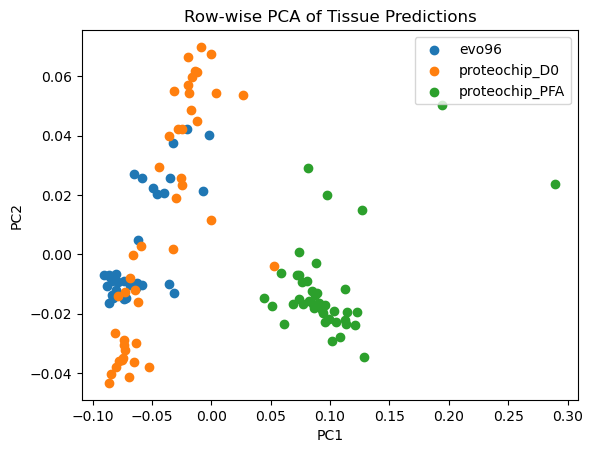

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'n_proteins']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Get the indices of samples from the current dataset
    indices = prediction_df[prediction_df['dataset'] == name].index
    
    # Plot the reduced data with color based on the dataset
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


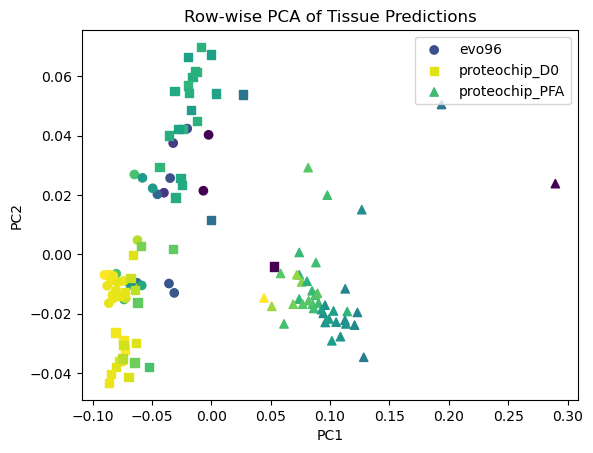

In [7]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'n_proteins']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Get the indices of samples from the current dataset
    indices = prediction_df[prediction_df['dataset'] == name].index
    
    # Get the number of proteins for each sample
    n_proteins = prediction_df.loc[indices, 'n_proteins']
    
    # Set the marker type based on the dataset
    marker = 'o' if name == 'evo96' else 's' if name == 'proteochip_D0' else '^'
    
    # Plot the reduced data with color and marker type
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], c=n_proteins, marker=marker, label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


So, the protein PCA does not show tremendous differences but the predictions do!  
This can be caused by the fact that MLMarker looks at less proteins than are present within the sample and maybe those are just different? Let's remake the protein PCA with only those proteins

In [8]:
features_path = "/home/compomics/git/MLMarker/models/binary_features_TP_4000features_95to75missingness_2024.txt"
with open(features_path, 'r') as features_file:
    features = features_file.read().split(',\n')


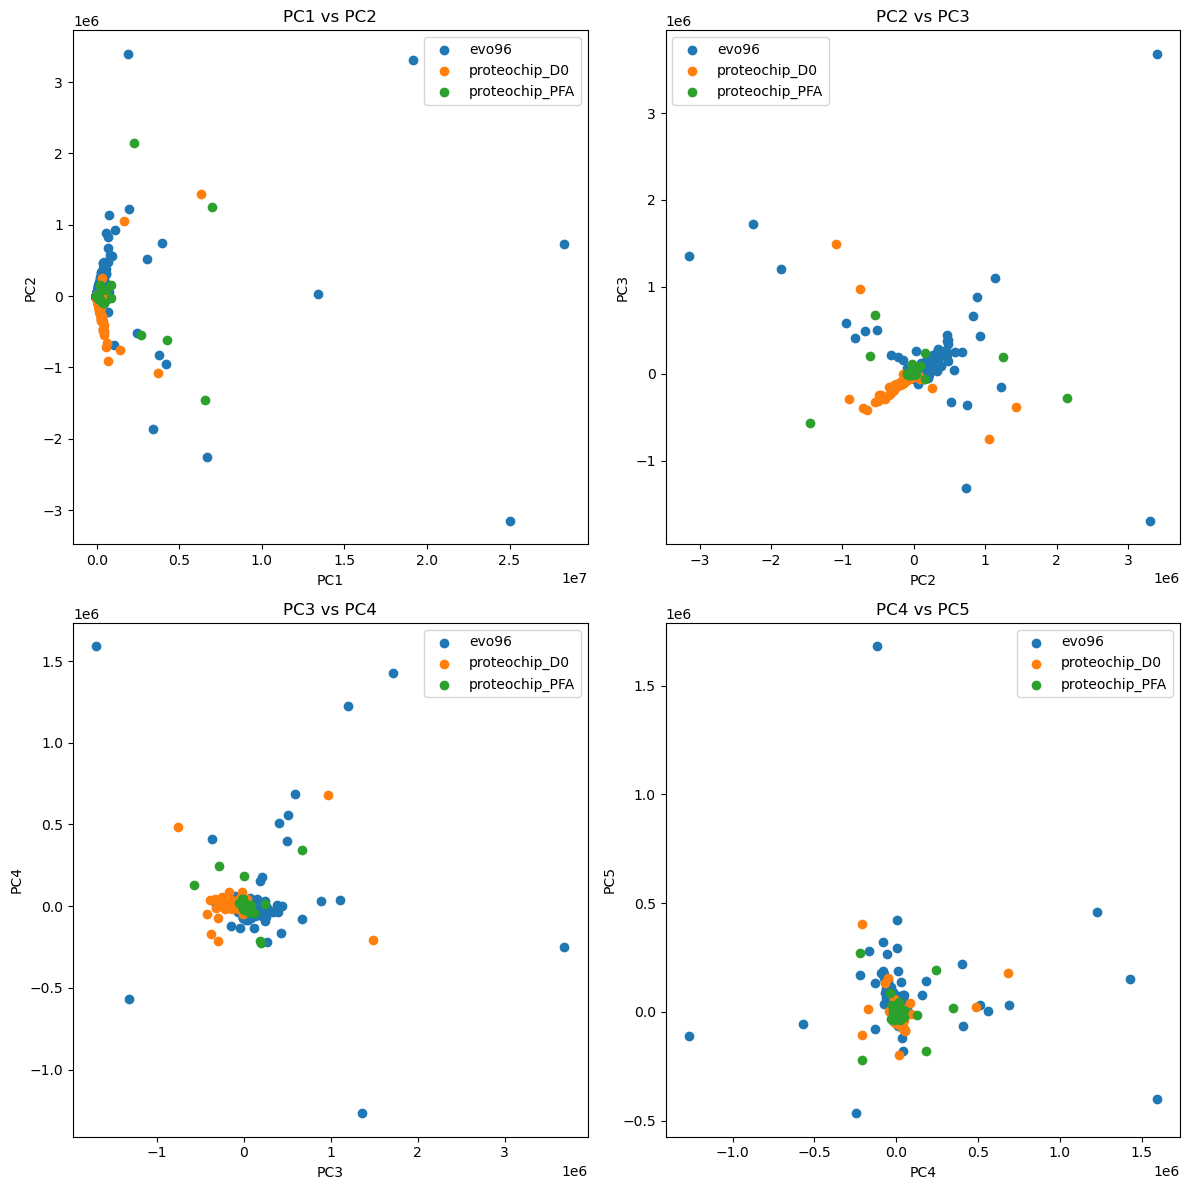

In [ ]:
#PCA with MLMarker features

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']

# Create a figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    # Read the data
    df = pd.read_csv(dataset, sep='\t')
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    df = df[df['Protein.Ids'].isin(features)] #only use the MLMarker proteins
    #add the missing proteins with 0 values
    missing_proteins = list(set(features) - set(df['Protein.Ids']))
    #add the missing proteins to the protein.ids column with zero values across the whole row
    df = pd.concat([df, pd.DataFrame(np.zeros((len(missing_proteins), df.shape[1])), columns=df.columns.tolist())])
    df = df.set_index('Protein.Ids')
    data = df.iloc[:, 5:].fillna(0).values
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=5)
    reduced_data = pca.fit_transform(data)
    
    # Plot the reduced data with color based on the dataset
    axs[0, 0].scatter(reduced_data[:, 0], reduced_data[:, 1], label=name)
    axs[0, 1].scatter(reduced_data[:, 1], reduced_data[:, 2], label=name)
    axs[1, 0].scatter(reduced_data[:, 2], reduced_data[:, 3], label=name)
    axs[1, 1].scatter(reduced_data[:, 3], reduced_data[:, 4], label=name)

# Add labels and titles for each subplot
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].legend()

axs[0, 1].set_title('PC2 vs PC3')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].legend()

axs[1, 0].set_title('PC3 vs PC4')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].legend()

axs[1, 1].set_title('PC4 vs PC5')
axs[1, 1].set_xlabel('PC4')
axs[1, 1].set_ylabel('PC5')
axs[1, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


2764
3951
861


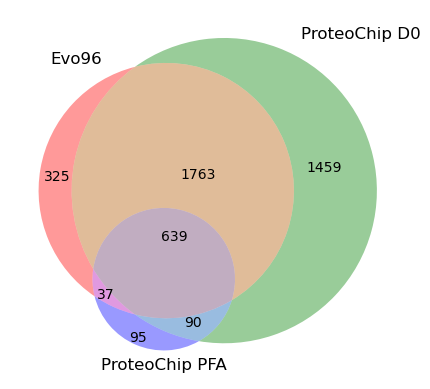

In [9]:
from matplotlib_venn import venn3
for i in protein_lists:
    print(len(i))
# Create the Venn diagram
venn3(protein_lists, ('Evo96', 'ProteoChip D0', 'ProteoChip PFA'))

There is no such difference from PFA on a protein level even with only the trained proteins (from which the missing ones are added as zero values).  
The most logical solution for this is that the lower amount of proteins within PFA impacts the prediction a lot which is not visible within the proteinlevel PCA.

This means that the MLMarker can detect levels at the proteome level which are not visible from the individual proteins. MLMarker is binary so it's also not a matter of higher or lower expressed proteins!  


In the tissue_predictions, the orange class shows a aparant linear spread. Does this correlate to any tissue prediction?

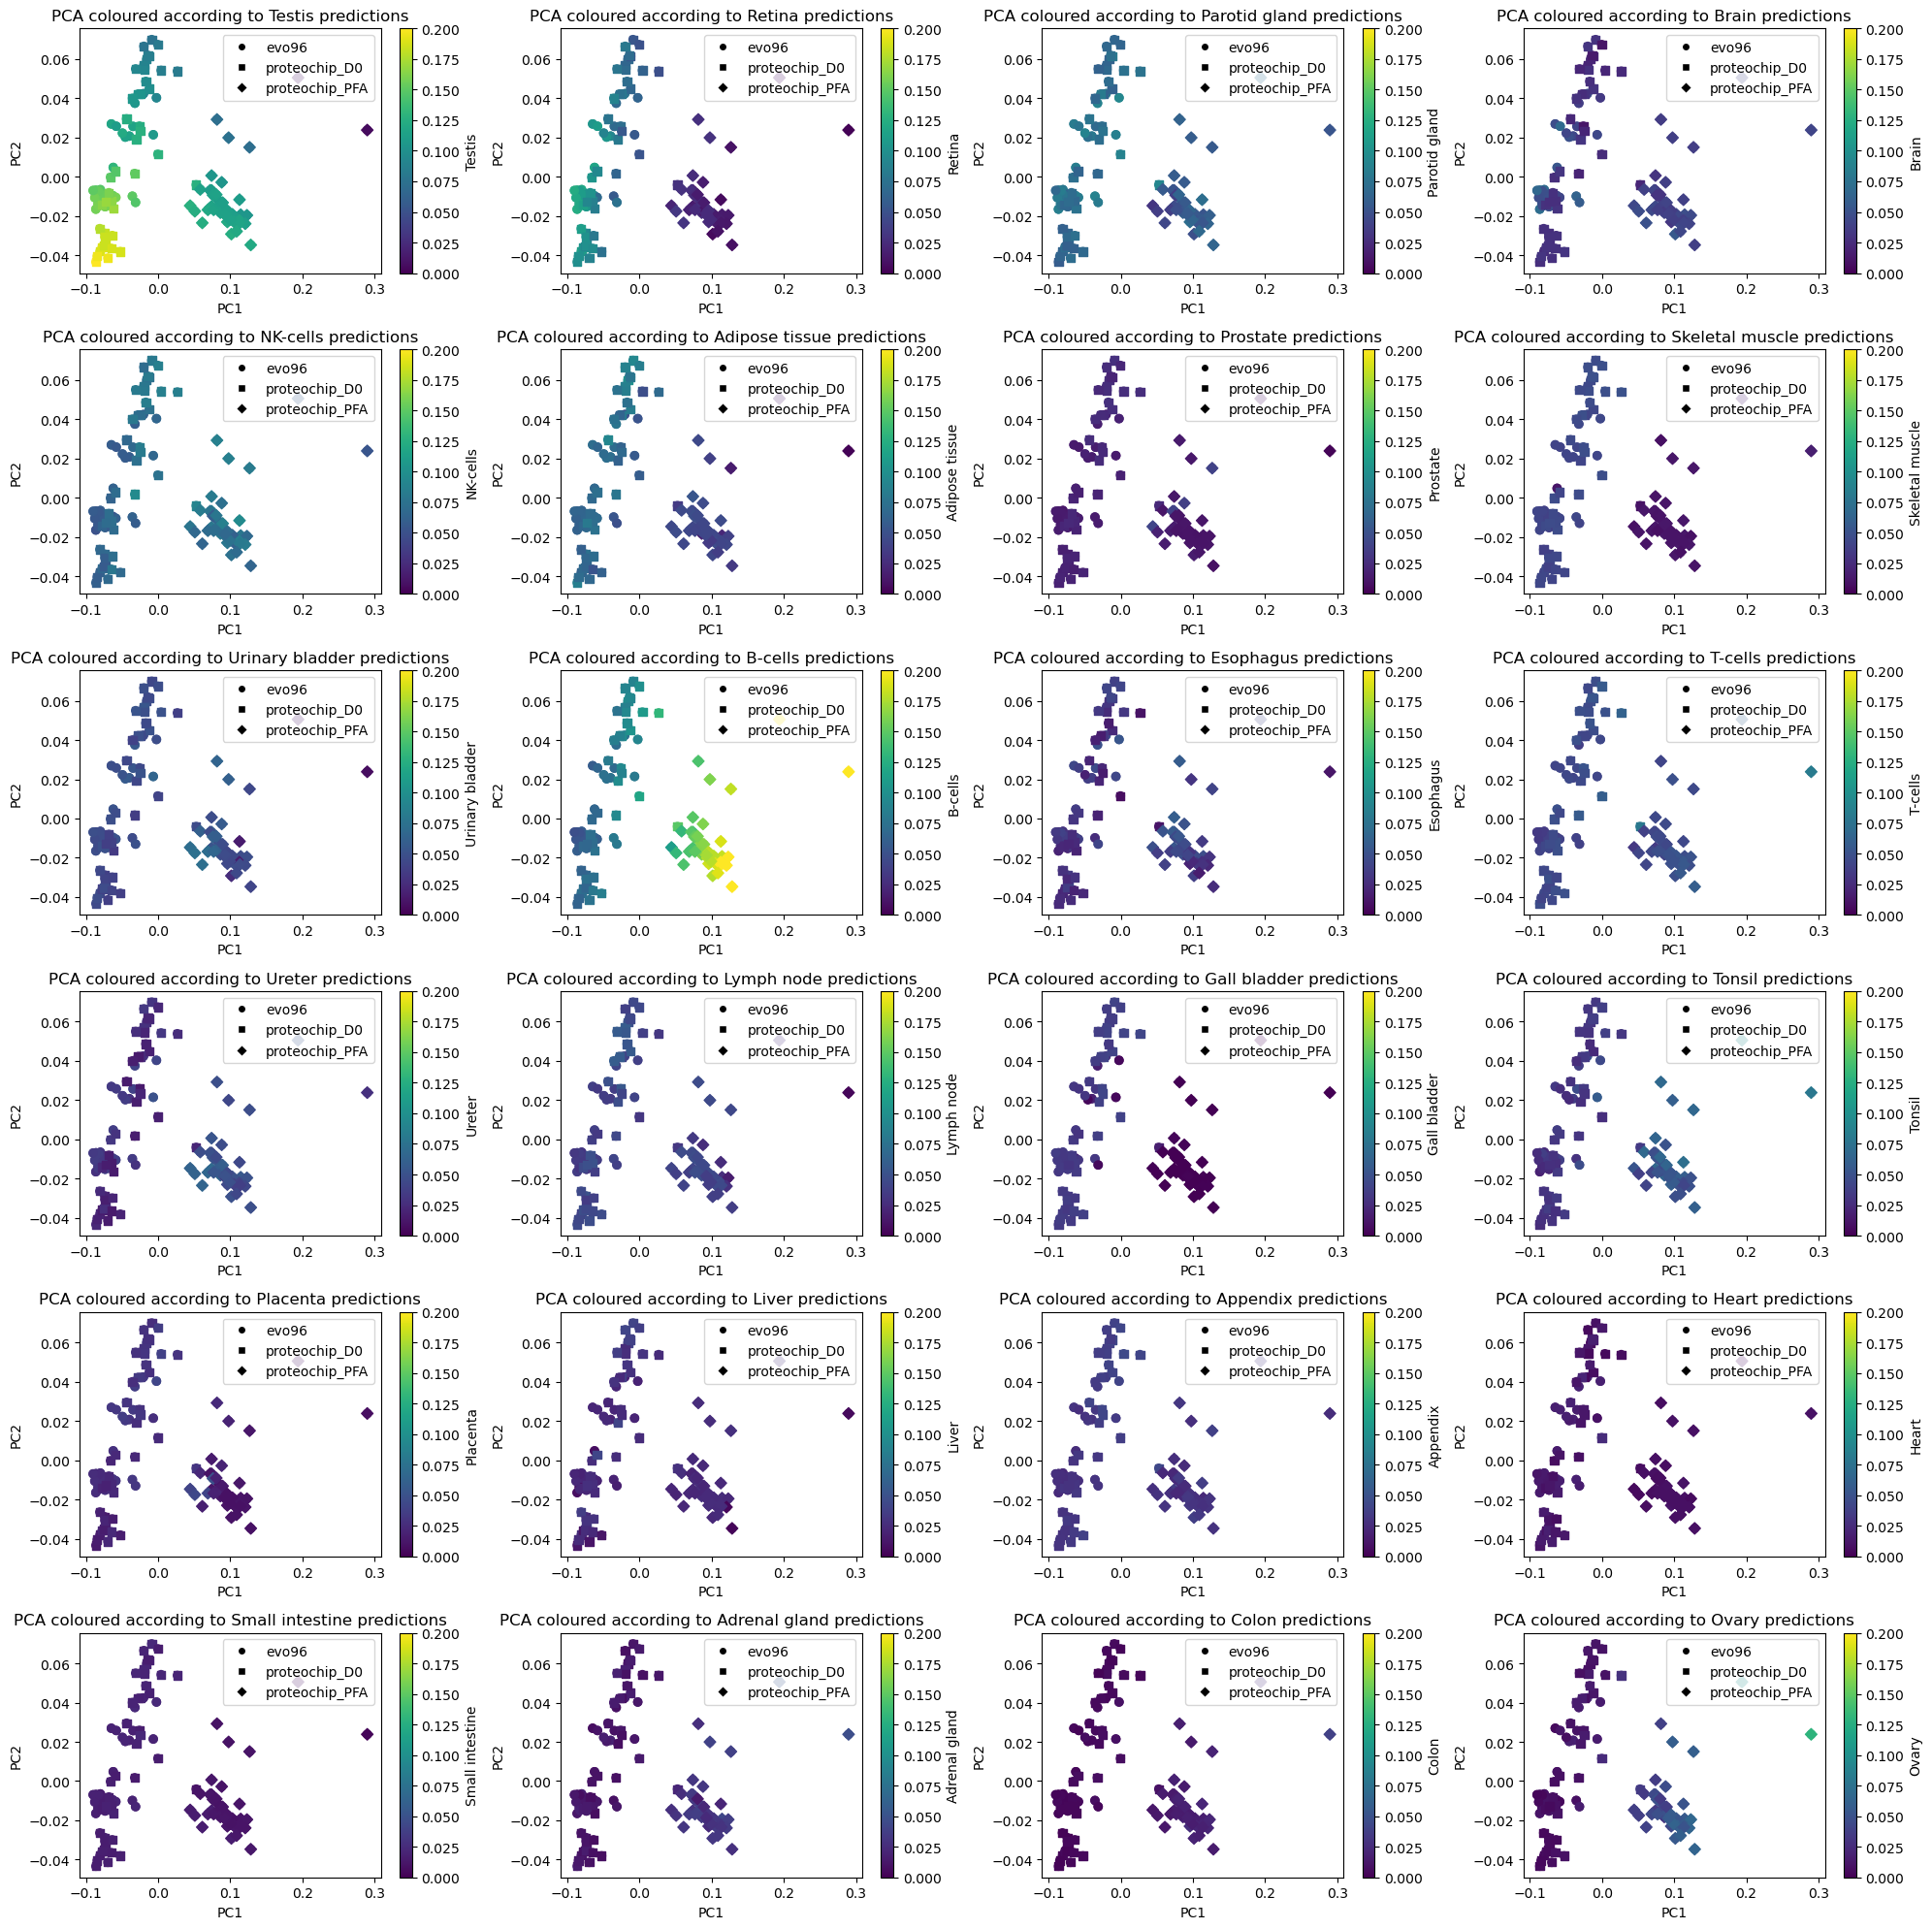

In [10]:



fig, axs = plt.subplots(6, 4, figsize=(20, 20))  # Create a figure with 6 rows and 4 columns

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(prediction_df.drop(columns=['sample', 'dataset', 'n_proteins']))
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca[['Testis', 'Retina', 'Parotid gland', 'Brain', 'Adipose tissue', 'Prostate', 'NK-cells', 
'Skeletal muscle', 'Urinary bladder', 'B-cells', 'Esophagus', 'T-cells', 'Ureter', 
'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 
'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']] = prediction_df.iloc[:, 3:]
df_pca[['sample', 'dataset']] = prediction_df[['sample', 'dataset']]

#add a column that states the number of proteins in the sample


tissues = ['Testis', 'Retina', 'Parotid gland', 'Brain', 'NK-cells', 'Adipose tissue', 'Prostate', 'Skeletal muscle', 'Urinary bladder', 'B-cells', 'Esophagus', 'T-cells', 'Ureter', 'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']

for i, t in enumerate(tissues):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index
    
    ax = axs[row, col]  # Select the current subplot
    
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[t], cmap='viridis', vmin=0, vmax=0.2)
    
    # Change marker type according to the dataset column
    markers = ['o', 's', 'D']  # Define marker types for each dataset
    
    for j, dataset in enumerate(df_pca['dataset'].unique()):
        indices = df_pca['dataset'] == dataset
        ax.scatter(df_pca.loc[indices, 'PC1'], df_pca.loc[indices, 'PC2'], c=df_pca.loc[indices, t], cmap='viridis', marker=markers[j], label=dataset, vmin=0, vmax=0.2)
    
    # Add legend for marker type
    legend_markers = [plt.Line2D([0], [0], marker=marker, color='w', label=dataset, markerfacecolor='k') for marker, dataset in zip(markers, df_pca['dataset'].unique())]
    ax.legend(handles=legend_markers)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(t)
    
    # Add labels and title
    ax.set_title(f'PCA coloured according to {t} predictions')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



PFA shows a strong correlation to high B-cell prediction and low Retina prediction. ==> is this because of the low amount of proteins?  
There is no direct correlation between the clustering and the amount of proteins in the sample.  

Is the PFA prediction for e.g. B-cells mainly based on missing features?   
The linear range within D0 seems to be related to decreasing Testis & Retina similarity 

# 2. Which tissue uses the most present proteins as features in its predictions?

In [11]:
x=MLMarker.shap_values_df(test)
counts = x[x>0].count(axis=1)
for ti, c in counts.items():
    print(ti, c)

B-cells 919
Testis 541
NK-cells 627
Parotid gland 845
Ovary 958


make one confidence score     
formula:  
Confidence Scoreclass = Probabilityclass × (∑(Positive Present Features)−∑(Negative Present Features)/Total Present Features)−(∑(Positive Absent Features)+∑(Negative Absent Features)/Total Features)   
* Probability  
* First term: reward positive present features
* Second term: penalizing absent features independent of their impact   

A negative confidence score: big impact of negative influences (absent or negative present features)

In [85]:
import pandas as pd
import tqdm

datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']
# Create a new dataframe to store the predictions
neg_counts_df = pd.DataFrame(columns=['dataset', 'sample','Testis',  'Retina',  'Parotid gland',  'Brain',  'Adipose tissue',  'Prostate',  'NK-cells',  'Skeletal muscle',  'Urinary bladder',  'B-cells',  'Esophagus',  'T-cells',  'Ureter',  'Lymph node',  'Gall bladder',  'Tonsil',  'Placenta',  'Liver',  'Appendix',  'Heart',  'Small intestine',  'Adrenal gland',  'Colon',  'Ovary'])
# Initialize a dataframe to store results
results_df = pd.DataFrame(columns=['sample', 'tissue', 'probability', 'confidence_score'])

for name, dataset in zip(names, datasets):
    print(f"started on {name}")
    df = pd.read_csv(dataset, sep='\t')
    df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
    sub_df = df.set_index('Protein.Ids')
    sample_proteins = sub_df.index
    sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
    sub_df = sub_df.loc[:,~sub_df.columns.duplicated()]
    sub_df = sub_df.T
    sub_df.fillna(0, inplace=True)
    sub_df = sub_df.astype(float)


    # Loop through each sample
    for i in tqdm.tqdm(range(sub_df.shape[0])):

        sample_data = sub_df.iloc[i:i+1, :]
        present_proteins = sample_data.T[sample_data.T != 0].index.tolist()
        absent_proteins = sample_data.T[sample_data.T == 0].index.tolist()
        # Perform the prediction
        test = MLMarker(sample_data, binary=True)
        predictions = MLMarker.predict_top_tissues(test, n_preds=100)  # Get top 100 predictions with probabilities
        
        # Get the SHAP values for the sample
        shap_df = MLMarker.shap_values_df(test, n_preds=100) # Assuming shap_values_df aligns with the sample index
        shap_df = shap_df.T

        # Vectorized lookups for present and absent proteins
        is_present = shap_df.index.isin(present_proteins)
        is_absent = ~is_present

        # Initialize a list to store results for this sample
        sample_results = []
        # Loop through each predicted tissue class and its probability
        for tissue, prob in predictions:
            # For each tissue prediction, calculate SHAP contributions
            shap_subset = shap_df[[tissue]]

            positive_present = shap_subset[(shap_subset[tissue] > 0) & is_present].sum().values[0]
            negative_present = shap_subset[(shap_subset[tissue] < 0) & is_present].sum().values[0]

            positive_absent = shap_subset[(shap_subset[tissue] > 0) & is_absent].sum().values[0]
            negative_absent = shap_subset[(shap_subset[tissue] < 0) & is_absent].sum().values[0]

            # Calculate the confidence score
            total_present = len(present_proteins)
            total_features = shap_df.shape[0]
            confidence_score = prob * ((positive_present / (positive_present + negative_present)) *
                (1 - (positive_absent + negative_absent) / total_features))
 # Append the result for this tissue to the list
            sample_results.append({
                'dataset': name,
                'sample': name + '_' + str(sub_df.index[i]),  # Sample name
                'tissue': tissue,
                'probability': prob,
                'confidence_score': confidence_score
            })
        
        # Convert the results for the current sample into a DataFrame and append to the final results dataframe
        sample_df = pd.DataFrame(sample_results)
        results_df = pd.concat([results_df, sample_df], ignore_index=True)
    print('Done')


started on evo96


  0%|          | 0/35 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  3%|▎         | 1/35 [00:02<01:23,  2.46s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  6%|▌         | 2/35 [00:04<01:21,  2.48s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


  9%|▊         | 3/35 [00:07<01:19,  2.47s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 11%|█▏        | 4/35 [00:09<01:16,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 14%|█▍        | 5/35 [00:12<01:13,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 17%|█▋        | 6/35 [00:14<01:10,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 20%|██        | 7/35 [00:17<01:08,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 23%|██▎       | 8/35 [00:19<01:05,  2.43s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 26%|██▌       | 9/35 [00:21<01:03,  2.43s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 29%|██▊       | 10/35 [00:24<01:01,  2.46s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 31%|███▏      | 11/35 [00:26<00:58,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 34%|███▍      | 12/35 [00:29<00:56,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 37%|███▋      | 13/35 [00:31<00:53,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 40%|████      | 14/35 [00:34<00:51,  2.43s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 43%|████▎     | 15/35 [00:36<00:48,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 46%|████▌     | 16/35 [00:39<00:46,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 49%|████▊     | 17/35 [00:41<00:45,  2.52s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 51%|█████▏    | 18/35 [00:44<00:42,  2.51s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 54%|█████▍    | 19/35 [00:46<00:39,  2.49s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 57%|█████▋    | 20/35 [00:49<00:37,  2.47s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 60%|██████    | 21/35 [00:51<00:34,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 63%|██████▎   | 22/35 [00:54<00:31,  2.46s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 66%|██████▌   | 23/35 [00:56<00:29,  2.46s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 69%|██████▊   | 24/35 [00:58<00:27,  2.46s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 71%|███████▏  | 25/35 [01:01<00:24,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 74%|███████▍  | 26/35 [01:03<00:22,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 77%|███████▋  | 27/35 [01:06<00:19,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 80%|████████  | 28/35 [01:08<00:17,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 83%|████████▎ | 29/35 [01:11<00:14,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 86%|████████▌ | 30/35 [01:13<00:12,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 89%|████████▊ | 31/35 [01:16<00:09,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 91%|█████████▏| 32/35 [01:18<00:07,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 94%|█████████▍| 33/35 [01:20<00:04,  2.45s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


 97%|█████████▋| 34/35 [01:23<00:02,  2.44s/it]

Error: Sample columns do not match model features
Error: Features are 6894 and should be 6877
6894 6877


100%|██████████| 35/35 [01:25<00:00,  2.45s/it]


Done
started on proteochip_D0


  0%|          | 0/44 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  2%|▏         | 1/44 [00:03<02:25,  3.39s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  5%|▍         | 2/44 [00:06<02:15,  3.24s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  7%|▋         | 3/44 [00:09<02:11,  3.21s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  9%|▉         | 4/44 [00:12<02:07,  3.20s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 11%|█▏        | 5/44 [00:16<02:04,  3.18s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 14%|█▎        | 6/44 [00:19<02:00,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 16%|█▌        | 7/44 [00:22<01:57,  3.18s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 18%|█▊        | 8/44 [00:25<01:53,  3.15s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 20%|██        | 9/44 [00:28<01:49,  3.13s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 23%|██▎       | 10/44 [00:31<01:46,  3.13s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 25%|██▌       | 11/44 [00:34<01:43,  3.15s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 27%|██▋       | 12/44 [00:38<01:40,  3.15s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 30%|██▉       | 13/44 [00:41<01:37,  3.16s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 32%|███▏      | 14/44 [00:44<01:34,  3.15s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 34%|███▍      | 15/44 [00:47<01:31,  3.14s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 36%|███▋      | 16/44 [00:50<01:27,  3.13s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 39%|███▊      | 17/44 [00:53<01:24,  3.14s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 41%|████      | 18/44 [00:56<01:21,  3.14s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 43%|████▎     | 19/44 [01:00<01:18,  3.15s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 45%|████▌     | 20/44 [01:03<01:16,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 48%|████▊     | 21/44 [01:06<01:14,  3.24s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 50%|█████     | 22/44 [01:09<01:11,  3.23s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 52%|█████▏    | 23/44 [01:13<01:07,  3.22s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 55%|█████▍    | 24/44 [01:16<01:04,  3.21s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 57%|█████▋    | 25/44 [01:19<01:00,  3.19s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 59%|█████▉    | 26/44 [01:22<00:57,  3.18s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 61%|██████▏   | 27/44 [01:25<00:54,  3.18s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 64%|██████▎   | 28/44 [01:28<00:50,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 66%|██████▌   | 29/44 [01:32<00:47,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 68%|██████▊   | 30/44 [01:35<00:44,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 70%|███████   | 31/44 [01:38<00:41,  3.16s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 73%|███████▎  | 32/44 [01:41<00:38,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 75%|███████▌  | 33/44 [01:44<00:34,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 77%|███████▋  | 34/44 [01:47<00:31,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 80%|███████▉  | 35/44 [01:51<00:28,  3.19s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 82%|████████▏ | 36/44 [01:54<00:25,  3.18s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 84%|████████▍ | 37/44 [01:57<00:22,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 86%|████████▋ | 38/44 [02:00<00:18,  3.16s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 89%|████████▊ | 39/44 [02:03<00:15,  3.16s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 91%|█████████ | 40/44 [02:06<00:12,  3.17s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 93%|█████████▎| 41/44 [02:10<00:09,  3.25s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 95%|█████████▌| 42/44 [02:13<00:06,  3.23s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 98%|█████████▊| 43/44 [02:16<00:03,  3.21s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


100%|██████████| 44/44 [02:19<00:00,  3.18s/it]


Done
started on proteochip_PFA


  0%|          | 0/41 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  2%|▏         | 1/41 [00:01<01:00,  1.51s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  5%|▍         | 2/41 [00:02<00:58,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


  7%|▋         | 3/41 [00:04<00:56,  1.50s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 10%|▉         | 4/41 [00:06<00:55,  1.50s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 12%|█▏        | 5/41 [00:07<00:54,  1.50s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 15%|█▍        | 6/41 [00:08<00:52,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 17%|█▋        | 7/41 [00:10<00:50,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 20%|█▉        | 8/41 [00:11<00:48,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 22%|██▏       | 9/41 [00:13<00:49,  1.54s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 24%|██▍       | 10/41 [00:15<00:47,  1.52s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 27%|██▋       | 11/41 [00:16<00:45,  1.50s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 29%|██▉       | 12/41 [00:17<00:43,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 32%|███▏      | 13/41 [00:19<00:41,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 34%|███▍      | 14/41 [00:20<00:40,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 37%|███▋      | 15/41 [00:22<00:38,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 39%|███▉      | 16/41 [00:24<00:39,  1.57s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 41%|████▏     | 17/41 [00:25<00:37,  1.54s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 44%|████▍     | 18/41 [00:27<00:34,  1.52s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 46%|████▋     | 19/41 [00:28<00:33,  1.51s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 49%|████▉     | 20/41 [00:30<00:31,  1.50s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 51%|█████     | 21/41 [00:31<00:29,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 54%|█████▎    | 22/41 [00:33<00:28,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 56%|█████▌    | 23/41 [00:34<00:26,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 59%|█████▊    | 24/41 [00:36<00:25,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 61%|██████    | 25/41 [00:37<00:23,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 63%|██████▎   | 26/41 [00:39<00:22,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 66%|██████▌   | 27/41 [00:40<00:20,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 68%|██████▊   | 28/41 [00:41<00:19,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 71%|███████   | 29/41 [00:43<00:17,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 73%|███████▎  | 30/41 [00:44<00:16,  1.47s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 76%|███████▌  | 31/41 [00:46<00:14,  1.47s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 78%|███████▊  | 32/41 [00:47<00:13,  1.47s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 80%|████████  | 33/41 [00:49<00:11,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 83%|████████▎ | 34/41 [00:50<00:10,  1.48s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 85%|████████▌ | 35/41 [00:52<00:09,  1.55s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 88%|████████▊ | 36/41 [00:54<00:07,  1.54s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 90%|█████████ | 37/41 [00:55<00:06,  1.52s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 93%|█████████▎| 38/41 [00:56<00:04,  1.51s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 95%|█████████▌| 39/41 [00:58<00:02,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


 98%|█████████▊| 40/41 [00:59<00:01,  1.49s/it]

Error: Sample columns do not match model features
Error: Features are 6878 and should be 6877
6878 6877


100%|██████████| 41/41 [01:01<00:00,  1.50s/it]

Done


In [86]:
confidence_results_df = results_df.pivot_table(columns='tissue', values='confidence_score', index=['sample', 'dataset']).reset_index()

In [87]:
confidence_results_df.dataset.value_counts()

dataset
proteochip_D0     44
proteochip_PFA    41
evo96             35
Name: count, dtype: int64

evo96
proteochip_D0
proteochip_PFA


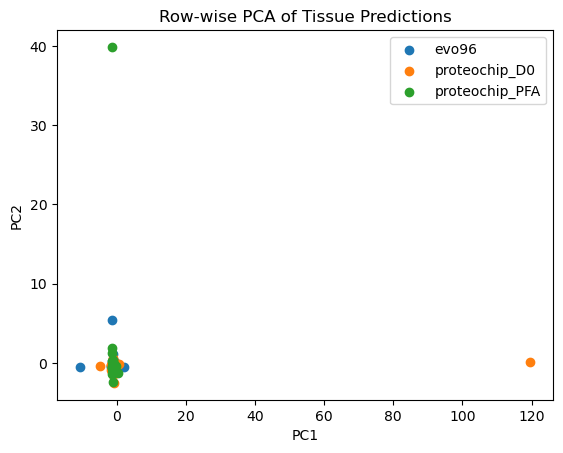

In [88]:
datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(confidence_results_df.fillna(0).drop(columns=['sample', 'dataset']))

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    print(name)
    # Get the indices of samples from the current dataset
    indices = confidence_results_df[confidence_results_df['dataset'] == name].index
    
    # Plot the reduced data with color based on the dataset
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=name)

# Add labels and title
ax.set_title('Row-wise PCA of Tissue Predictions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# Show the plot
plt.show()


In [89]:
confidence_results_df.head()

tissue,sample,dataset,Adipose tissue,Adrenal gland,Appendix,B-cells,Brain,Colon,Esophagus,Gall bladder,Heart,Liver,Lymph node,NK-cells,Ovary,Parotid gland,Placenta,Prostate,Retina,Skeletal muscle,Small intestine,T-cells,Testis,Tonsil,Ureter,Urinary bladder
0,evo96_TU014944PAP_Slot1-12_1_3201.d,evo96,0.105439,-0.002100,-0.116919,-0.018155,-0.329131,-0.000924,0.320001,0.061222,-0.032750,0.101684,0.237231,6.362879,-0.001437,0.314329,0.326709,-0.048643,0.085405,0.068555,-0.054231,-0.030570,0.166987,-0.075186,-0.178625,0.245011
1,evo96_TU014945PAP_Slot1-11_1_3202.d,evo96,0.112501,-0.005429,-0.049755,-0.014255,0.230816,-0.000753,-0.122515,0.074622,-0.033088,0.147784,2.860657,-0.219236,-0.000521,0.251697,5.277791,-0.025353,0.106314,0.072053,-0.045723,-0.021318,0.215538,-0.015452,-0.114060,0.331875
2,evo96_TU014946PAP_Slot1-10_1_3203.d,evo96,0.113364,-0.002529,-0.074836,-0.020414,-0.430469,-0.001414,-0.692993,0.171868,-0.041042,0.122141,0.547939,-0.190920,-0.000729,0.246936,-0.993313,-0.032419,0.110540,0.072829,-0.052864,-0.023511,0.212912,-0.028121,-0.129200,0.281892
3,evo96_TU014947PAP_Slot1-09_1_3204.d,evo96,0.110750,-0.014813,-0.075592,-0.034800,-1.523863,-0.001042,-1.745329,1.091055,-0.044543,0.187973,0.519330,-0.552756,-0.006212,0.258497,-1.354702,-0.036502,0.108398,0.071020,-0.046735,-0.034387,0.169601,-0.035101,-0.049411,0.240724
4,evo96_TU014948PAP_Slot1-08_1_3205.d,evo96,0.091465,-0.012763,-0.439205,-0.029460,-4.563120,-0.000851,0.267780,0.065228,-0.058167,0.192400,0.195554,-1.186160,-0.008387,0.256039,0.527478,-0.086202,0.092795,0.068598,-0.086163,-0.036826,0.141874,-0.107864,-0.050973,0.438132


In [90]:
confidence_results_df.tail()

tissue,sample,dataset,Adipose tissue,Adrenal gland,Appendix,B-cells,Brain,Colon,Esophagus,Gall bladder,Heart,Liver,Lymph node,NK-cells,Ovary,Parotid gland,Placenta,Prostate,Retina,Skeletal muscle,Small intestine,T-cells,Testis,Tonsil,Ureter,Urinary bladder
115,proteochip_PFA_H:\Perdu-Alloy Pauline\organoid...,proteochip_PFA,0.052595,-0.028123,-0.091959,-2.551272,-0.113012,-0.004578,-0.068791,0.000000,-0.004961,-0.000733,0.076253,1.050926,-0.084533,-1.052272,-0.004525,-0.007092,0.028368,0.035903,-0.031154,-0.984003,0.140757,-0.067806,-0.452709,0.138272
116,proteochip_PFA_H:\Perdu-Alloy Pauline\organoid...,proteochip_PFA,0.054237,-0.078157,-0.195101,-0.387509,16.425794,-0.006644,-0.012519,-0.000151,-0.005186,0.043244,0.074971,0.522970,-0.058519,1.375874,-0.005673,-0.017993,0.022073,0.058408,-0.022626,-0.250230,0.141205,-0.022228,-0.110162,0.124322
117,proteochip_PFA_H:\Perdu-Alloy Pauline\organoid...,proteochip_PFA,0.054058,-0.009113,-0.131959,-0.324709,-0.035629,-0.020303,-0.019639,0.000000,-0.011566,0.042985,0.076528,0.217045,-0.014885,0.600281,-0.005909,-0.016189,0.029365,0.061218,-0.016396,-0.068183,0.141001,-0.042169,-0.129639,0.114703
118,proteochip_PFA_H:\Perdu-Alloy Pauline\organoid...,proteochip_PFA,0.054128,-0.028853,-0.090974,-0.261775,-0.094588,-0.005152,-0.048489,0.000000,-0.004881,0.044419,0.077265,0.322355,-0.081301,-3.295910,-0.004100,-0.010483,0.030120,0.045948,-0.012126,-0.082369,0.138885,-0.057055,-0.301145,0.135445
119,proteochip_PFA_H:\Perdu-Alloy Pauline\organoid...,proteochip_PFA,0.059796,-0.017224,-0.138204,-0.229247,-0.106245,-0.006945,0.246142,-0.001518,-0.004202,0.044070,0.080749,0.820969,-0.052893,-0.167854,-0.004068,-0.010662,0.030126,0.061261,-0.017698,-0.081211,0.138662,-0.044336,-0.384788,0.128037


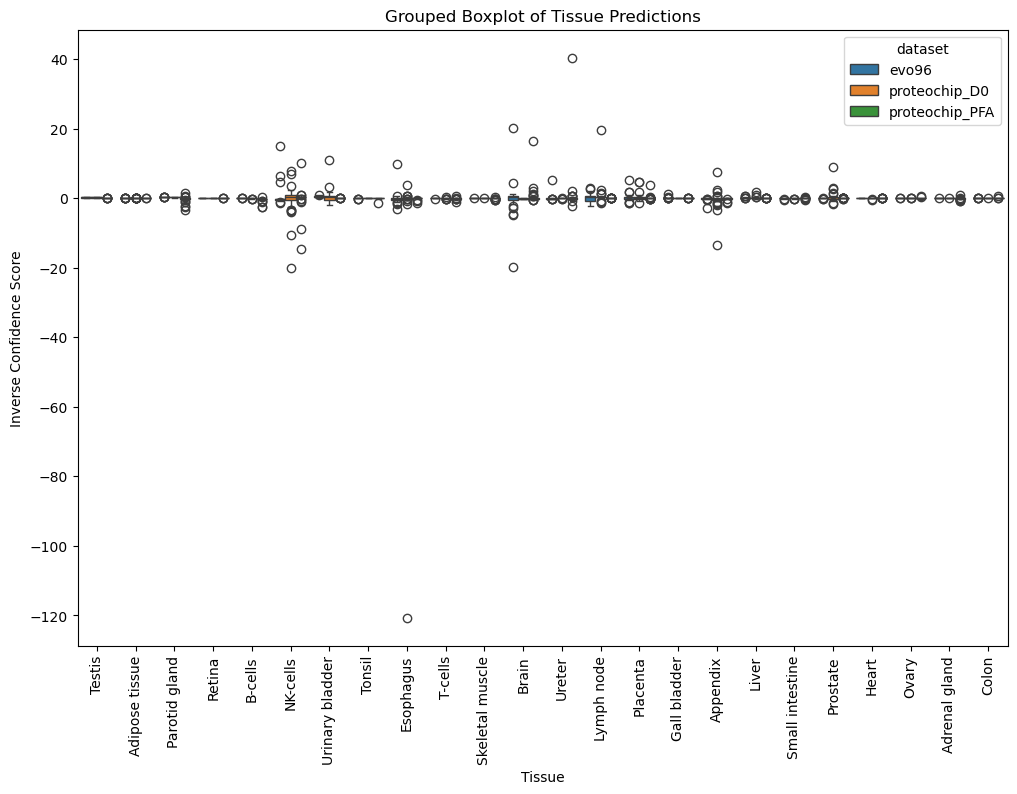

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the grouped boxplot
sns.boxplot(data=results_df, x='tissue', y='confidence_score', hue='dataset')

# Add labels and title
plt.xlabel('Tissue')
plt.ylabel('Inverse Confidence Score')
plt.title('Grouped Boxplot of Tissue Predictions')
plt.xticks(rotation=90)
# Show the plot
plt.show()


In [79]:
pd.set_option('display.max_columns', None)
confidence_results_df.drop(columns=['sample']).groupby('dataset').sum()

tissue,Adipose tissue,Adrenal gland,Appendix,B-cells,Brain,Colon,Esophagus,Gall bladder,Heart,Liver,Lymph node,NK-cells,Ovary,Parotid gland,Placenta,Prostate,Retina,Skeletal muscle,Small intestine,T-cells,Testis,Tonsil,Ureter,Urinary bladder
dataset,,,,,,,,,,,,,,,,,,,,,,,,
evo96,-4.750588e-07,-3.475637e-08,-1.779745e-07,-8.023544e-07,-5.312667e-07,-6.007963e-09,-3.007547e-07,-5.364349e-08,-3.804733e-08,-3.089254e-08,-2.276149e-07,-7.998453e-07,-3.525785e-08,-2.184734e-06,-1.661198e-07,-2.381500e-08,-3.172558e-07,-8.300875e-08,-3.327041e-08,-2.393862e-07,-0.000004,-3.352093e-07,-3.101996e-07,-6.809165e-07
proteochip_D0,-9.293846e-07,-3.471837e-08,-4.176282e-07,-2.431976e-06,-1.693702e-07,-8.673324e-09,-2.111219e-07,-1.161154e-07,-3.805426e-08,-9.010615e-08,-7.696556e-07,-1.923520e-06,-5.228059e-08,-2.065128e-06,-1.692714e-07,-8.922991e-08,-3.479145e-08,-1.032130e-07,-4.811551e-08,-5.487743e-07,-0.000008,-3.373991e-07,-1.671672e-07,-8.104607e-07
proteochip_PFA,-8.216153e-08,-7.902454e-08,-6.578576e-08,-2.718744e-06,-8.887058e-08,-2.339681e-08,-2.935787e-07,-3.380502e-11,-2.253600e-09,-2.658796e-08,-1.218170e-07,-4.683519e-07,-2.766289e-07,-2.144764e-07,-3.044511e-08,-1.981833e-08,-9.789156e-10,-2.107137e-09,-6.638295e-09,-8.733960e-08,-0.000001,-4.167374e-07,-3.089667e-07,-2.824743e-07


In [72]:
highest_value = confidence_results_df.iloc[:,2:].max().max()
lowest_value = confidence_results_df.iloc[:,2:].min().min()

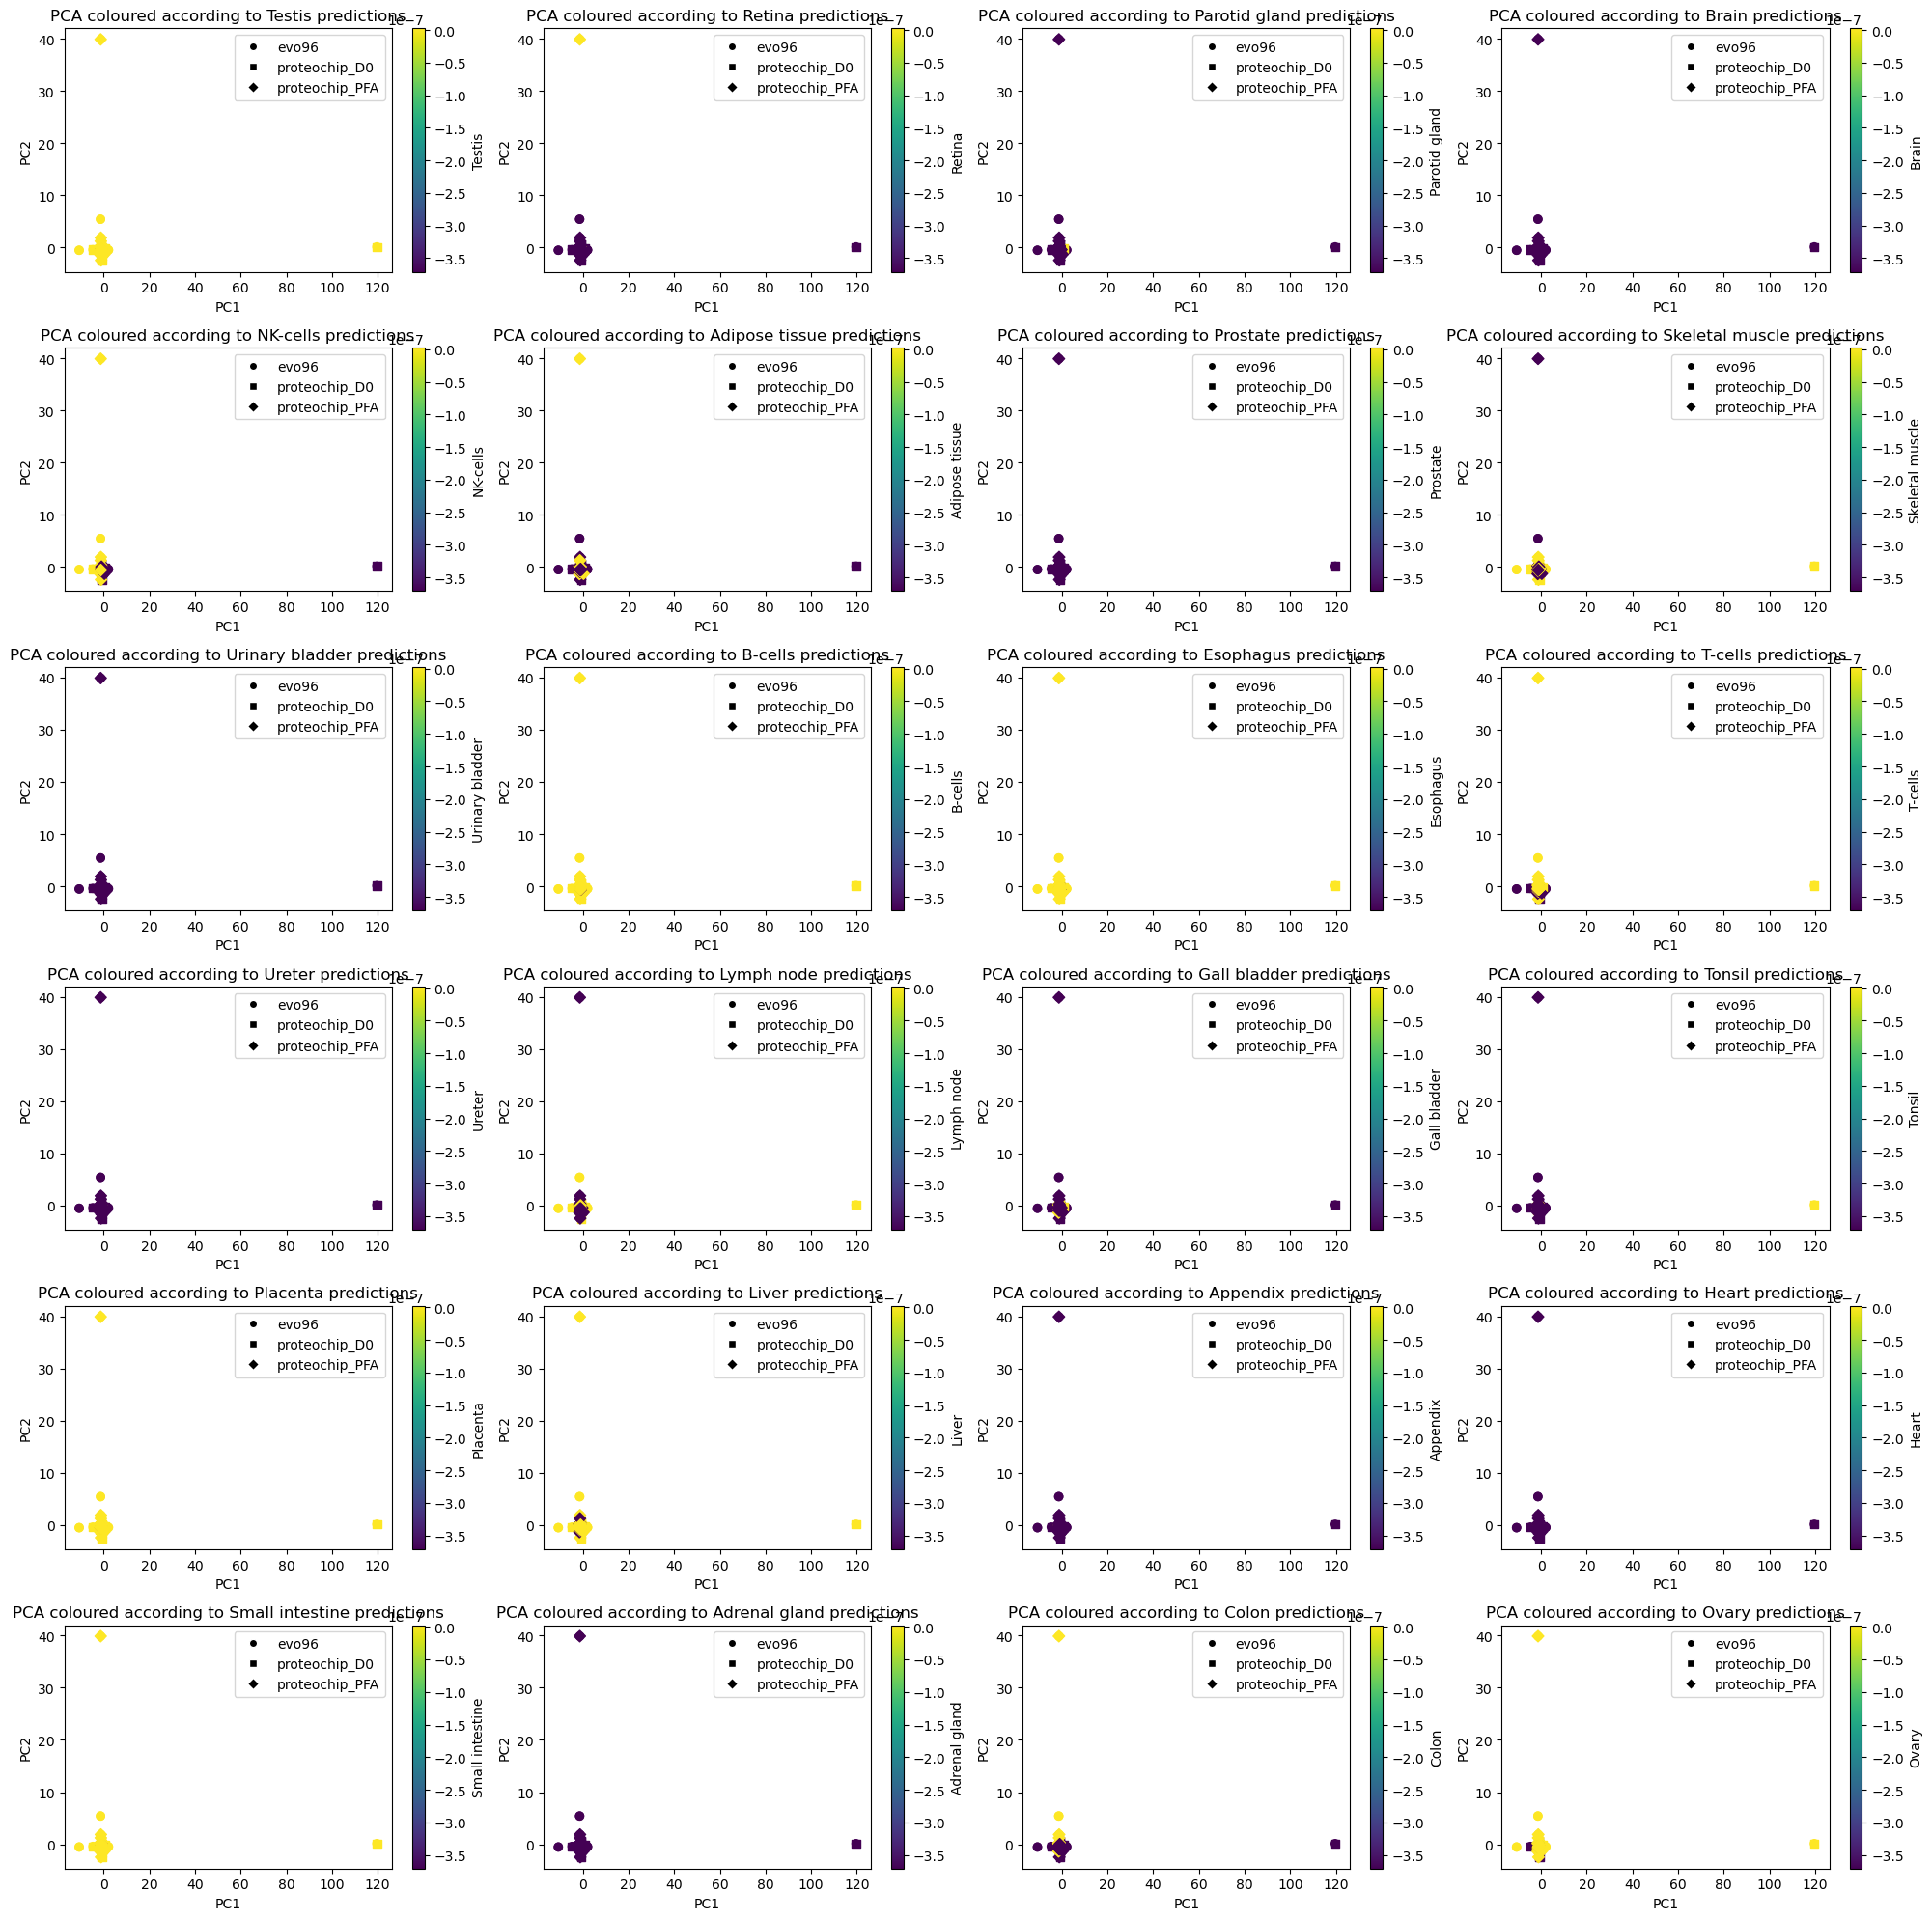

In [92]:
fig, axs = plt.subplots(6, 4, figsize=(20, 20))  # Create a figure with 6 rows and 4 columns

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(confidence_results_df.drop(columns=['sample', 'dataset']))
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca[['Testis', 'Retina', 'Parotid gland', 'Brain', 'Adipose tissue', 'Prostate', 'NK-cells', 
'Skeletal muscle', 'Urinary bladder', 'B-cells', 'Esophagus', 'T-cells', 'Ureter', 
'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 
'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']] = confidence_results_df.iloc[:, 2:]
df_pca[['sample', 'dataset']] = confidence_results_df[['sample', 'dataset']]

#add a column that states the number of proteins in the sample


tissues = ['Testis', 'Retina', 'Parotid gland', 'Brain', 'NK-cells', 'Adipose tissue', 'Prostate', 'Skeletal muscle', 'Urinary bladder', 'B-cells', 'Esophagus', 'T-cells', 'Ureter', 'Lymph node', 'Gall bladder', 'Tonsil', 'Placenta', 'Liver', 'Appendix', 'Heart', 'Small intestine', 'Adrenal gland', 'Colon', 'Ovary']

for i, t in enumerate(tissues):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index
    
    ax = axs[row, col]  # Select the current subplot
    
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[t], cmap='viridis', vmin=lowest_value, vmax = highest_value)
    
    # Change marker type according to the dataset column
    markers = ['o', 's', 'D']  # Define marker types for each dataset
    
    for j, dataset in enumerate(df_pca['dataset'].unique()):
        indices = df_pca['dataset'] == dataset
        ax.scatter(df_pca.loc[indices, 'PC1'], df_pca.loc[indices, 'PC2'], c=df_pca.loc[indices, t], cmap='viridis', vmin=lowest_value, vmax = highest_value, marker=markers[j], label=dataset)
    
    # Add legend for marker type
    legend_markers = [plt.Line2D([0], [0], marker=marker, color='w', label=dataset, markerfacecolor='k') for marker, dataset in zip(markers, df_pca['dataset'].unique())]
    ax.legend(handles=legend_markers)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(t)
    
    # Add labels and title
    ax.set_title(f'PCA coloured according to {t} predictions')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



# 3. Continuing with the proteochipD0 data, how different are individual cells?  

This dataset showed the most variability within this group. Are these single cells very different from each other?


In [120]:
#all proteins combined
df = pd.read_csv("proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
# if it contains ';' split it and take both
proteins = [x.split(';') for x in proteins]
proteins = [item for sublist in proteins for item in sublist]
proteins = list(set(proteins))

#make a dataframe with the proteins as column names, only one row and all values 1
data = np.ones((1, len(proteins)))
predict_df = pd.DataFrame(data, columns=proteins)

test = MLMarker(predict_df.iloc[0:1,:], binary = True)
prediction = MLMarker.predict_top_tissues(test, n_preds=12)
print(i, prediction)

43 [('Testis', 0.2238), ('Retina', 0.1265), ('Esophagus', 0.0554), ('Parotid gland', 0.0529), ('Adipose tissue', 0.0522), ('Skeletal muscle', 0.052), ('Prostate', 0.0481), ('NK-cells', 0.0441), ('B-cells', 0.0393), ('Brain', 0.0366), ('Lymph node', 0.0341), ('T-cells', 0.0333)]


In [3]:
import tqdm as tqdm
#individual samples
df = pd.read_csv("proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
df['Protein.Ids'] = df['Protein.Ids'].astype(str).str.split(';').str[0]
sub_df = df.set_index('Protein.Ids')
sub_df.drop(columns=['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'], inplace=True)
sub_df = sub_df.T
sub_df.fillna(0, inplace=True)
sub_df = sub_df.astype(float)

# Create a new dataframe to store the predictions
prediction_df2 = pd.DataFrame(columns=['sample','Testis',  'Retina',  'Esophagus','Parotid gland',  'Brain',  'Adipose tissue',  'Skeletal muscle', 
'Prostate',  'NK-cells',  'B-cells', 'Urinary bladder',   'Lymph node',    'T-cells',  'Ureter',  
 'Gall bladder',  'Tonsil',  'Placenta',  'Liver',  'Appendix',  'Heart',  'Small intestine',  'Adrenal gland', 
 'Colon',  'Ovary'])

# Predict and add the predictions to the dataframe
for i in tqdm.tqdm(range(sub_df.shape[0])):
    test = MLMarker(sub_df.iloc[i:i+1,:], binary=True)
    prediction = MLMarker.predict_top_tissues(test, n_preds=100)
    prediction_df2.loc[i, 'sample'] = sub_df.index[i]
    for tissue, prob in prediction:
        prediction_df2.loc[i, tissue] = prob

#drop columns with only nan
prediction_df2.dropna(axis=1, how='all', inplace=True)


  0%|          | 0/44 [00:00<?, ?it/s]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  2%|▏         | 1/44 [00:02<01:52,  2.62s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  5%|▍         | 2/44 [00:05<01:50,  2.63s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  7%|▋         | 3/44 [00:07<01:47,  2.62s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


  9%|▉         | 4/44 [00:10<01:45,  2.63s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 11%|█▏        | 5/44 [00:13<01:44,  2.67s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 14%|█▎        | 6/44 [00:15<01:40,  2.65s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 16%|█▌        | 7/44 [00:18<01:37,  2.63s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 18%|█▊        | 8/44 [00:21<01:35,  2.65s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 20%|██        | 9/44 [00:23<01:32,  2.64s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 23%|██▎       | 10/44 [00:26<01:30,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 25%|██▌       | 11/44 [00:29<01:27,  2.65s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 27%|██▋       | 12/44 [00:31<01:25,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 30%|██▉       | 13/44 [00:34<01:22,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 32%|███▏      | 14/44 [00:37<01:19,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 34%|███▍      | 15/44 [00:39<01:18,  2.70s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 36%|███▋      | 16/44 [00:42<01:15,  2.70s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 39%|███▊      | 17/44 [00:45<01:12,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 41%|████      | 18/44 [00:47<01:09,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 43%|████▎     | 19/44 [00:50<01:06,  2.67s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 45%|████▌     | 20/44 [00:53<01:03,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 48%|████▊     | 21/44 [00:55<01:01,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 50%|█████     | 22/44 [00:58<00:58,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 52%|█████▏    | 23/44 [01:01<00:56,  2.70s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 55%|█████▍    | 24/44 [01:03<00:53,  2.70s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 57%|█████▋    | 25/44 [01:06<00:50,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 59%|█████▉    | 26/44 [01:09<00:48,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 61%|██████▏   | 27/44 [01:12<00:45,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 64%|██████▎   | 28/44 [01:14<00:42,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 66%|██████▌   | 29/44 [01:17<00:40,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 68%|██████▊   | 30/44 [01:19<00:37,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 70%|███████   | 31/44 [01:22<00:34,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 73%|███████▎  | 32/44 [01:25<00:32,  2.70s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 75%|███████▌  | 33/44 [01:28<00:29,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 77%|███████▋  | 34/44 [01:30<00:26,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 80%|███████▉  | 35/44 [01:33<00:24,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 82%|████████▏ | 36/44 [01:36<00:21,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 84%|████████▍ | 37/44 [01:38<00:18,  2.68s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 86%|████████▋ | 38/44 [01:41<00:15,  2.67s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 89%|████████▊ | 39/44 [01:44<00:13,  2.66s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 91%|█████████ | 40/44 [01:46<00:10,  2.67s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 93%|█████████▎| 41/44 [01:49<00:08,  2.70s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 95%|█████████▌| 42/44 [01:52<00:05,  2.72s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


 98%|█████████▊| 43/44 [01:54<00:02,  2.71s/it]

Error: Sample columns do not match model features
Error: Features are 6893 and should be 6877
6893 6877


100%|██████████| 44/44 [01:57<00:00,  2.67s/it]


Brain shows consistent correlation to testis and retina and anticorrelation to all other tissues

<Axes: >

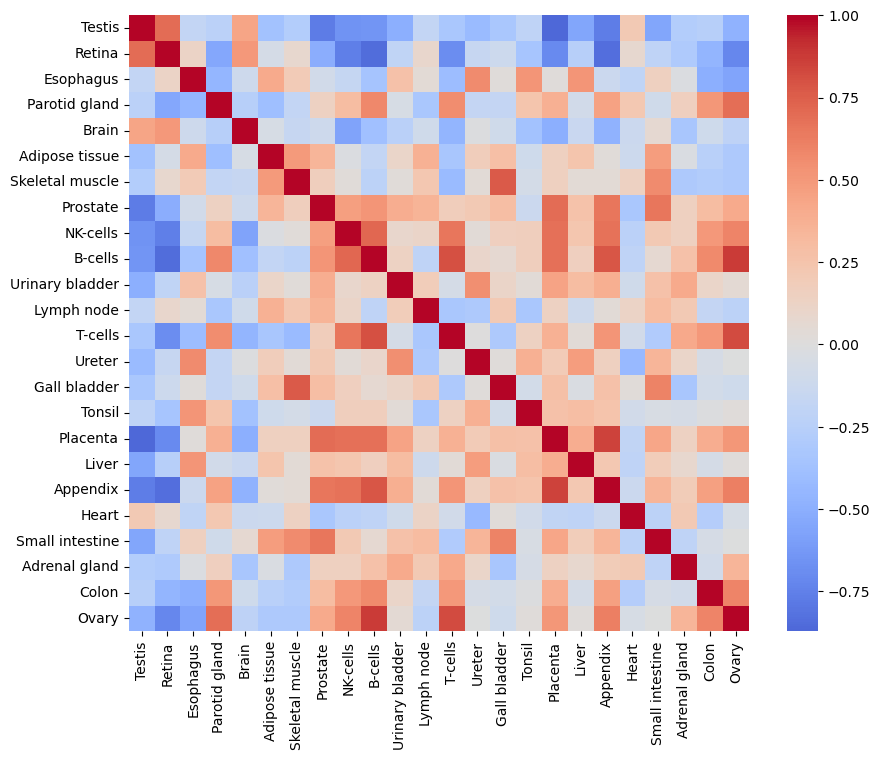

In [4]:
correlation_matrix = prediction_df2.set_index('sample').corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)


# 3. PFA dataset: why is this one so different?